In [34]:
import tushare as ts
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

# for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

df = pd.read_csv('data/PA_daily.csv')

#print the head
# print(len(df))
df.head(20)

2364


,trade_date,open,high,low,close,amount
0,20200701,12.79,13.15,12.74,13.12,2202800.843
1,20200630,12.83,12.88,12.72,12.80,1199181.601
2,20200629,12.92,12.97,12.71,12.80,1330678.288
3,20200624,12.64,12.88,12.60,12.80,1946329.095
4,20200623,12.65,12.69,12.52,12.60,1248046.646
5,20200622,12.74,12.76,12.62,12.64,1671023.278
6,20200619,12.73,12.84,12.61,12.80,1954584.919
7,20200618,12.76,12.80,12.59,12.76,1419972.017
8,20200617,12.89,12.92,12.76,12.85,918251.153
9,20200616,12.90,12.99,12.86,12.89,927043.687


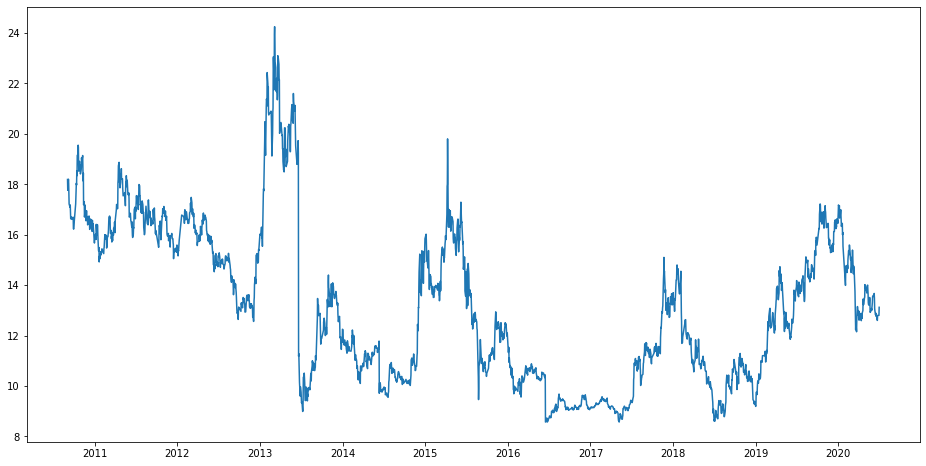

In [5]:
df['trade_date'] = pd.to_datetime(df.trade_date, format='%Y%m%d')
df.index = df['trade_date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['close'], label='Close Price history')

In [7]:
#creating dataframe with date and the target variable
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['trade_date', 'close'])

In [8]:
for i in range(0,len(data)):
    new_data['trade_date'][i] = data['trade_date'][i]
    new_data['close'][i] = data['close'][i]

In [14]:
# splitting into train and validation
train = new_data[:1891]
valid = new_data[1892:]

# shapes of training set
print('\n Shape of training set:')
print(train.shape)

# shapes of validation set
print('\n Shape of validation set:')
print(valid.shape)

# In the next step, we will create predictions for the validation set and check the RMSE using the actual values.
# making predictions
preds = []
for i in range(0,valid.shape[0]):
    a = train['close'][len(train)-248+i:].sum() + sum(preds)
    b = a/248
    preds.append(b)

# checking the results (RMSE value)
rms=np.sqrt(np.mean(np.power((np.array(valid['close'])-preds),2)))
print('\n RMSE value on validation set:')
print(rms)


 Shape of training set:
(1891, 2)

 Shape of validation set:
(472, 2)

 RMSE value on validation set:
4.959775943007833


C:\Users\JAYHAN02\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\JAYHAN02\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


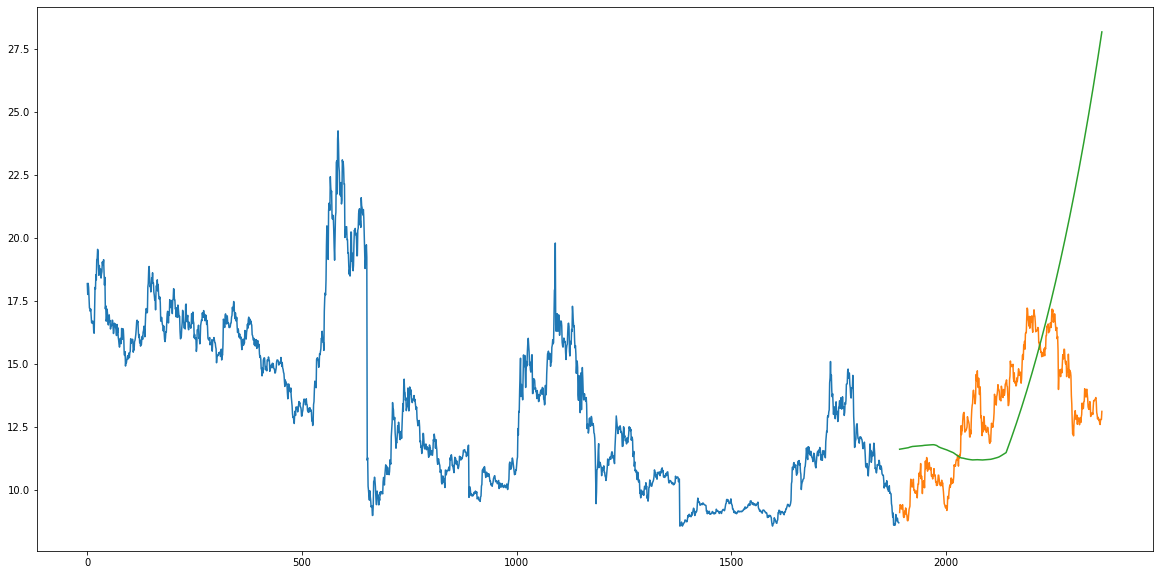

In [17]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])

In [32]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['trade_date', 'close'])
for i in range(0,len(data)):
    new_data['trade_date'][i] = data['trade_date'][i]
    new_data['close'][i] = data['close'][i]

#setting index
new_data.index = new_data.trade_date
new_data.drop('trade_date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:1891,:]
valid = dataset[1891:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

1891

In [27]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

0.34343604729527755

C:\Users\JAYHAN02\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


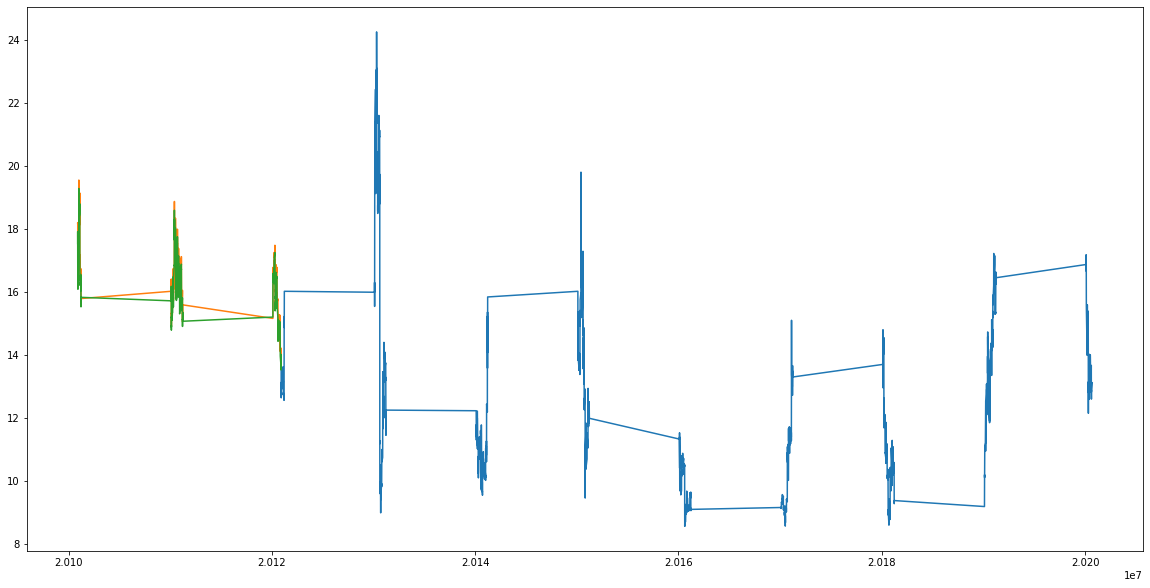

In [28]:
#for plotting
train = new_data[:1891]
valid = new_data[1891:]
valid['Predictions'] = closing_price
plt.plot(train['close'])
plt.plot(valid[['close','Predictions']])

In [40]:
#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [41]:
#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_valid)

ValueError: Found array with dim 3. MinMaxScaler expected <= 2.

In [42]:
pro = ts.pro_api()

df = pro.daily(ts_code='000001.SZ', start_date='20201201', end_date='20201216')

In [43]:
df.head()

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,000001.SZ,20201216,18.80,19.10,18.58,19.01,18.74,0.27,1.4408,689070.42,1302133.815
1,000001.SZ,20201215,18.80,18.85,18.15,18.74,18.88,-0.14,-0.7415,788857.94,1458268.620
2,000001.SZ,20201214,18.60,19.06,18.50,18.88,18.52,0.36,1.9438,835991.74,1575396.008
3,000001.SZ,20201211,18.71,18.80,18.22,18.52,18.65,-0.13,-0.6971,887793.87,1642392.314
4,000001.SZ,20201210,18.73,18.88,18.45,18.65,18.71,-0.06,-0.3207,607866.55,1130916.254
